In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import GPy
from getdist import plots, MCSamples

from gpr4im import fg_tools as fg
from gpr4im import pk_tools as pk
from gpr4im import obs_tools as obs

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

# Running GPR analysis on our with polarisation data

Loading data and `pymultinest` nested sampling results for the model:

`RBF (smooth foregrounds) + RBF (polarised foregrounds) + Exponential (21cm) + zero noise`

In [3]:
# data:
data = pd.read_pickle('../../Data/data.pkl')
FGwpol_HI_noise_data = data.beam.FGwpol_HI_noise
HI_noise_data = data.beam.HI_noise
freqs = data.freqs
# multinest results:
multinest_results = pd.read_pickle('../../Data/multinest_results.pkl')
multinest = multinest_results.wpol

Perform PCA removal, to compare with GPR:

In [4]:
pca_res_6 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=6)[0]
pca_res_7 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=7)[0]

We plot below the posterior distribution of our kernel hyperparameters.

In [5]:
samples = multinest.samples
samples[:,0] = samples[:,0]/1e4
samples[:,4] = samples[:,4]/1e-3
weights = multinest.weights

mask = weights > 1e-4

names = ['fgvar', 'fglen', 'polvar', 'pollen', 'expvar', 'explen']
labels =  ['$\sigma_\mathrm{smooth} / 10^4$', '$\ell_\mathrm{smooth}$', '$\sigma_\mathrm{pol}$', 
           '$\ell_\mathrm{pol}$', '$\sigma_{21} / 10^{-3}$', '$\ell_{21}$']
samples_plot = MCSamples(samples=samples[mask,:], weights=weights[mask], names = names, labels = labels)

Removed no burn in


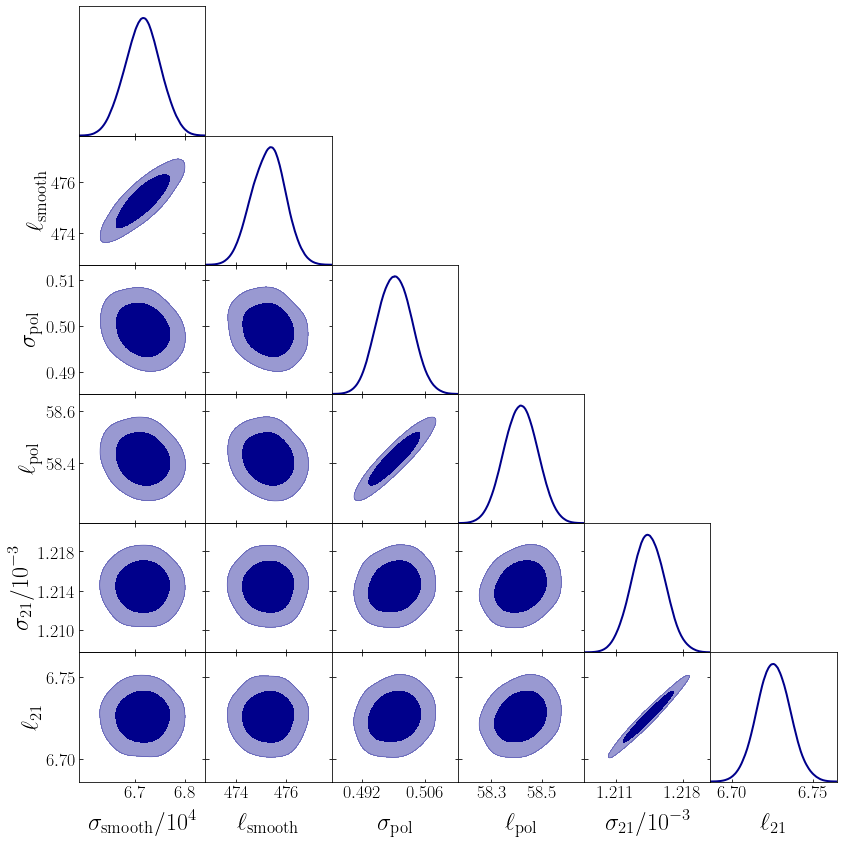

In [6]:
g = plots.get_subplot_plotter()
samples_plot.updateSettings({'contours': [0.68, 0.95]})
g.settings.axes_labelsize=27
g.settings.axes_fontsize=21
g.settings.legend_fontsize=22
g.settings.axis_marker_lw=2
g.settings.axis_marker_ls='dotted'
g.triangle_plot([samples_plot], filled=True,
                legend_loc='upper right',
                line_args=[{'lw':2, 'color':'darkblue'}],
                contour_colors=['darkblue'],fontsize=22)

#g.export('../figs/posterior_wpol.pdf')

Perform GPR removal using this model:

In [7]:
kern_smooth = GPy.kern.RBF(1, variance = multinest.rbf1_var, lengthscale = multinest.rbf1_len)
kern_pol = GPy.kern.RBF(1, variance = multinest.rbf2_var, lengthscale = multinest.rbf2_len)
kern_fg = kern_smooth + kern_pol
kern_21 = GPy.kern.Exponential(1, variance = multinest.exp_var, lengthscale = multinest.exp_len)

Input = FGwpol_HI_noise_data

gpr_result = fg.GPRclean(Input, freqs, kern_fg, kern_21, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


In [8]:
gpr_result.model

GP_regression.,value,constraints,priors
sum.rbf.variance,67161.78736295136,+ve,
sum.rbf.lengthscale,475.3038673456153,+ve,
sum.rbf_1.variance,0.4992046749695261,+ve,
sum.rbf_1.lengthscale,58.41604678366568,+ve,
sum.Exponential.variance,0.0012143664675416637,+ve,
sum.Exponential.lengthscale,6.725670650710272,+ve,
Gaussian_noise.variance,0.0,+ve fixed,


Plotting power spectra

In [9]:
# Dimension of data cube:
lx, ly, lz = 1000,1000, 924.78 #Mpc/h
nx, ny, nz = 256, 256, 285
# weighting and window function:
w = W = np.ones((nx,ny,nz))

# minimum and maximum k in each direction:
kmin, kmin_perp, kmin_par = 2*np.pi/pow(lx*ly*lz, 1/3), 2*np.pi/np.sqrt(lx**2 + ly**2), 2*np.pi/lz
kmax, kmax_par, kmax_perp = 0.4, 0.4, 0.4

# set width of k bins to be 2*kmin
dk, dk_perp, dk_par = 2*kmin, 2*kmin_perp, 2*kmin_par

# number of k bins:
nkbin = int((kmax-kmin)/dk)
nkbin_perp = int((kmax_perp-kmin_perp)/dk_perp)
nkbin_par = int((kmax_par-kmin_par)/dk_par)

# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
kbins_perp = np.arange(kmin_perp,kmax_perp,dk_perp)
kbins_par = np.arange(kmin_par,kmax_par,dk_par)

# array of kbin centers:
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
kperp = np.linspace(kmin_perp+0.5*dk_perp,kmax_perp-0.5*dk_perp,nkbin_perp)
kpar = np.linspace(kmin_par+0.5*dk_par,kmax_par-0.5*dk_par,nkbin_par)

Calculate 3D Pk:

In [10]:
# true HI power spectrum:
HI_pk = pk.getpk(HI_noise_data, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

# residual power spectrum from GPR:
GPR_pk = pk.getpk(gpr_result.res, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

# residual power spectrum from PCA:
PCA7_pk = pk.getpk(pca_res_7, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]
PCA6_pk = pk.getpk(pca_res_6, w, W, nx, ny, nz, lx, ly, lz, kbins)[0]

From now on when we refer to "GPR Residual" we will be speaking of the bias corrected residual.

Calculate 1D P($k_\parallel$)

In [11]:
# true HI power spectrum:
HI_pk_para = pk.ParaPk(HI_noise_data, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]

# residual power spectrum from GPR:
GPR_pk_para = pk.ParaPk(gpr_result.res, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]

# residual power spectrum from PCA:
PCA7_pk_para = pk.ParaPk(pca_res_7, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]
PCA6_pk_para = pk.ParaPk(pca_res_6, nx, ny, nz, lx, ly, lz, kbins_par, w, W)[0]

Calculate 1D P($k_\perp$)

In [12]:
# true HI power spectrum:
HI_pk_perp = pk.PerpPk(HI_noise_data, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

# residual power spectrum from GPR, with bias correction:
GPR_pk_perp = pk.PerpPk(gpr_result.res, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

# residual power spectrum from PCA:
PCA7_pk_perp = pk.PerpPk(pca_res_7, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]
PCA6_pk_perp = pk.PerpPk(pca_res_6, nx, ny, nz, lx, ly, lz, kbins_perp, w, W)[0]

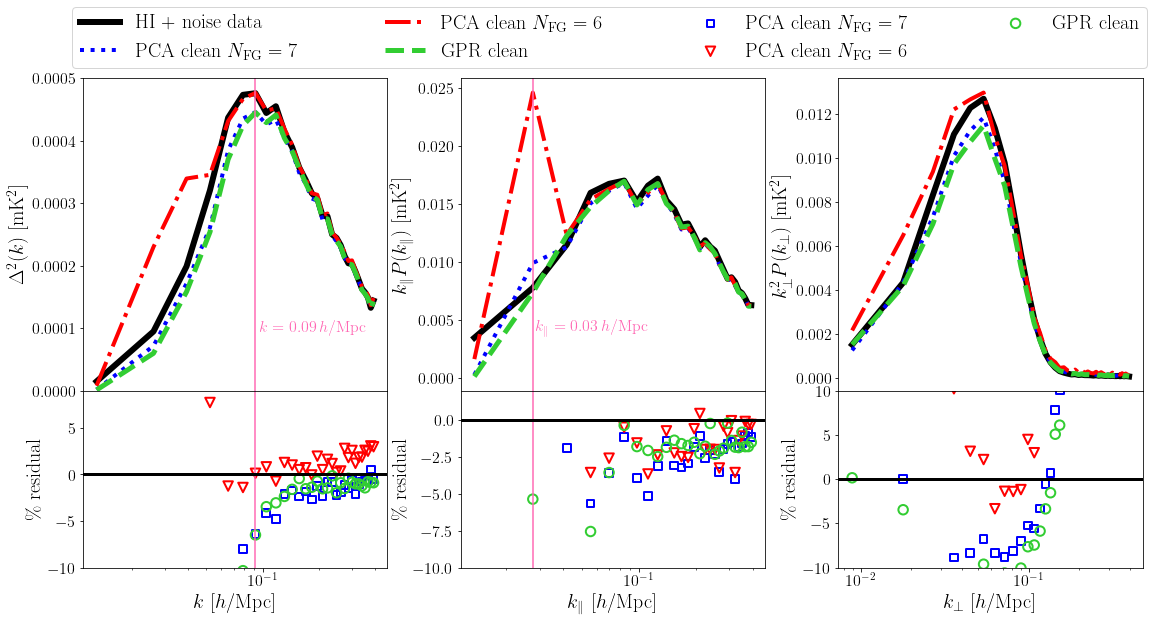

In [14]:
fig, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(nrows=2, ncols=3, sharex='col', 
                                                       figsize=(19,9), gridspec_kw={'height_ratios': [3, 1.7]})
fig.subplots_adjust(hspace=0, wspace=0.24)

ax1.plot(k, (k*k*k*HI_pk)/(2*np.pi*np.pi), ls='solid', c='k', lw=6, label = r'HI + noise data')
ax1.plot(k, (k*k*k*PCA7_pk)/(2*np.pi*np.pi), ls='dotted',c='b', lw=4)
ax1.plot(k, (k*k*k*PCA6_pk)/(2*np.pi*np.pi), ls='dashdot',c='r', lw=4)
ax1.plot(k, (k*k*k*GPR_pk)/(2*np.pi*np.pi), ls='dashed', c='limegreen', lw=5)
ax1.text(k[0]*7.4, 0.000095, r'$k = 0.09 \, h$/Mpc', c='hotpink')
ax1.axvline(k[6], c='hotpink')
ax1.set_xscale('log')
ax1.set_ylim(0,0.0005)
ax1.set_ylabel('$\Delta^2 (k)$ [mK$^2$]', fontsize=20)

ax2.scatter(k, 100*(PCA7_pk - HI_pk)/HI_pk, marker='s', s=60, edgecolor='b', facecolor='none', lw=2, label = r'PCA clean $N_{\rm FG} = 7$')
ax2.scatter(k, 100*(PCA6_pk - HI_pk)/HI_pk, marker='v', s=90, edgecolor='r', facecolor='none', lw=2, label = r'PCA clean $N_{\rm FG} = 6$')
ax2.scatter(k, 100*(GPR_pk - HI_pk)/HI_pk, s=90, marker='o', edgecolor='limegreen', facecolor='none', lw=2, label = r'GPR clean')
ax2.set_ylim(-10,9)
ax2.axvline(k[6], c='hotpink')
ax2.axhline(0, c='k', lw=3)
ax2.set_xscale('log')
ax2.set_xlabel('$k$ [$h$/Mpc]', fontsize=20)
ax2.set_ylabel('\% residual', fontsize=20)

ax3.plot(kpar, kpar*HI_pk_para, ls='solid', c='k', lw=6)
ax3.plot(kpar, kpar*PCA7_pk_para, ls='dotted',c='b', lw=4, label = r'PCA clean $N_{\rm FG} = 7$')
ax3.plot(kpar, kpar*PCA6_pk_para, ls='dashdot',c='r', lw=4)
ax3.plot(kpar, kpar*GPR_pk_para, ls='dashed', c='limegreen', lw=5)
ax3.text(k[0]*2.2, 0.0041, r'$k_\parallel = 0.03 \, h$/Mpc', c='hotpink')
ax3.axvline(kpar[1], c='hotpink')
ax3.set_xscale('log')
ax3.set_ylabel('$k_\parallel P(k_\parallel)$ [mK$^2$]', fontsize=20)

ax4.scatter(kpar, 100*(PCA7_pk_para - HI_pk_para)/HI_pk_para, marker='s', s=60, edgecolor='b', facecolor='none', lw=2)
ax4.scatter(kpar, 100*(PCA6_pk_para - HI_pk_para)/HI_pk_para, marker='v', s=90, edgecolor='r', facecolor='none', lw=2)
ax4.scatter(kpar, 100*(GPR_pk_para - HI_pk_para)/HI_pk_para, s=90, marker='o', edgecolor='limegreen', facecolor='none', lw=2)
ax4.axvline(kpar[1], c='hotpink')
ax4.set_ylim(-10,2)
ax4.set_xscale('log')
ax4.set_xlabel('$k_\parallel$ [$h$/Mpc]', fontsize=20)
ax4.set_ylabel('\% residual', fontsize=20)
ax4.axhline(0, c='k', lw=3)

ax5.plot(kperp, kperp*kperp*HI_pk_perp, ls='solid', c='k', lw=6)
ax5.plot(kperp, kperp*kperp*PCA7_pk_perp, ls='dotted',c='b', lw=4)
ax5.plot(kperp, kperp*kperp*PCA6_pk_perp, ls='dashdot',c='r', lw=4, label = r'PCA clean $N_{\rm FG} = 6$')
ax5.plot(kperp, kperp*kperp*GPR_pk_perp, ls='dashed', c='limegreen', lw=5, label = r'GPR clean')
ax5.set_xscale('log')
ax5.set_ylabel('$k_\perp^2 P(k_\perp)$ [mK$^2$]', fontsize=20)

ax6.scatter(kperp, 100*(PCA7_pk_perp - HI_pk_perp)/HI_pk_perp, marker='s', s=60, edgecolor='b', facecolor='none', lw=2)
ax6.scatter(kperp, 100*(PCA6_pk_perp - HI_pk_perp)/HI_pk_perp, marker='v', s=90, edgecolor='r', facecolor='none', lw=2)
ax6.scatter(kperp, 100*(GPR_pk_perp - HI_pk_perp)/HI_pk_perp, s=90, marker='o', edgecolor='limegreen', facecolor='none', lw=2)
ax6.set_ylim(-10,10)
ax6.set_xlabel('$k_\perp$ [$h$/Mpc]', fontsize=20)
ax6.set_ylabel('\% residual', fontsize=20)
ax6.axhline(0, c='k', lw=3)

fig.legend(bbox_to_anchor=(0.11, 0.88, 0.8, 0), loc="lower left", mode="expand", ncol=4, fontsize=20)

#plt.savefig('figs/pk_all_wpol', dpi=300, bbox_inches="tight")

Looking at residual foregrounds in our data:

In [17]:
FGnopol_data = data.beam.foregrounds.all_nopol
FGwpol_data = data.beam.foregrounds.all_wpol
FGpol_data = data.beam.foregrounds.pleak
C_FGnopol = np.cov(obs.LoSpixels(FGnopol_data, mean_center=True))
C_FGwpol = np.cov(obs.LoSpixels(FGwpol_data, mean_center=True))
C_FGpol = np.cov(obs.LoSpixels(FGpol_data, mean_center=True))

In [18]:
# Choose your kernels, one for FG and one for HI signal
kern_smooth = GPy.kern.RBF(1, variance = multinest.rbf1_var, lengthscale = multinest.rbf1_len)
kern_pol = GPy.kern.RBF(1, variance = multinest.rbf2_var, lengthscale = multinest.rbf2_len)

# this extracts the foreground fit:
fgfit_nopol, fgcov_nopol = gpr_result.model.predict(freqs[:, np.newaxis], full_cov=True, kern=kern_smooth,
        include_likelihood=False)
cov_nopol = np.cov(fgfit_nopol)

fgfit_pol, fgcov_pol = gpr_result.model.predict(freqs[:, np.newaxis], full_cov=True, kern=kern_pol,
        include_likelihood=False)
cov_pol = np.cov(fgfit_pol)

fgfit_wpol, fgcov_wpol = gpr_result.model.predict(freqs[:, np.newaxis], full_cov=True, kern=kern_smooth+kern_pol,
        include_likelihood=False)
cov_wpol = np.cov(fgfit_wpol)

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [19]:
gpr_result_nopol_true = fg.GPRfit(FGnopol_data, freqs, kern_smooth, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)
fit_nopol_true = obs.LoSpixels(gpr_result_nopol_true.fit, mean_center=False)
cov_nopol_true = np.cov(fit_nopol_true)

gpr_result_pol_true = fg.GPRfit(FGpol_data, freqs, kern_pol, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)
fit_pol_true = obs.LoSpixels(gpr_result_pol_true.fit, mean_center=False)
cov_pol_true = np.cov(fit_pol_true)

gpr_result_wpol_true = fg.GPRfit(FGwpol_data, freqs, kern_smooth+kern_pol, num_restarts=0, NprePCA=0, 
                                        noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)
fit_wpol_true = obs.LoSpixels(gpr_result_wpol_true.fit, mean_center=False)
cov_wpol_true = np.cov(fit_wpol_true)

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


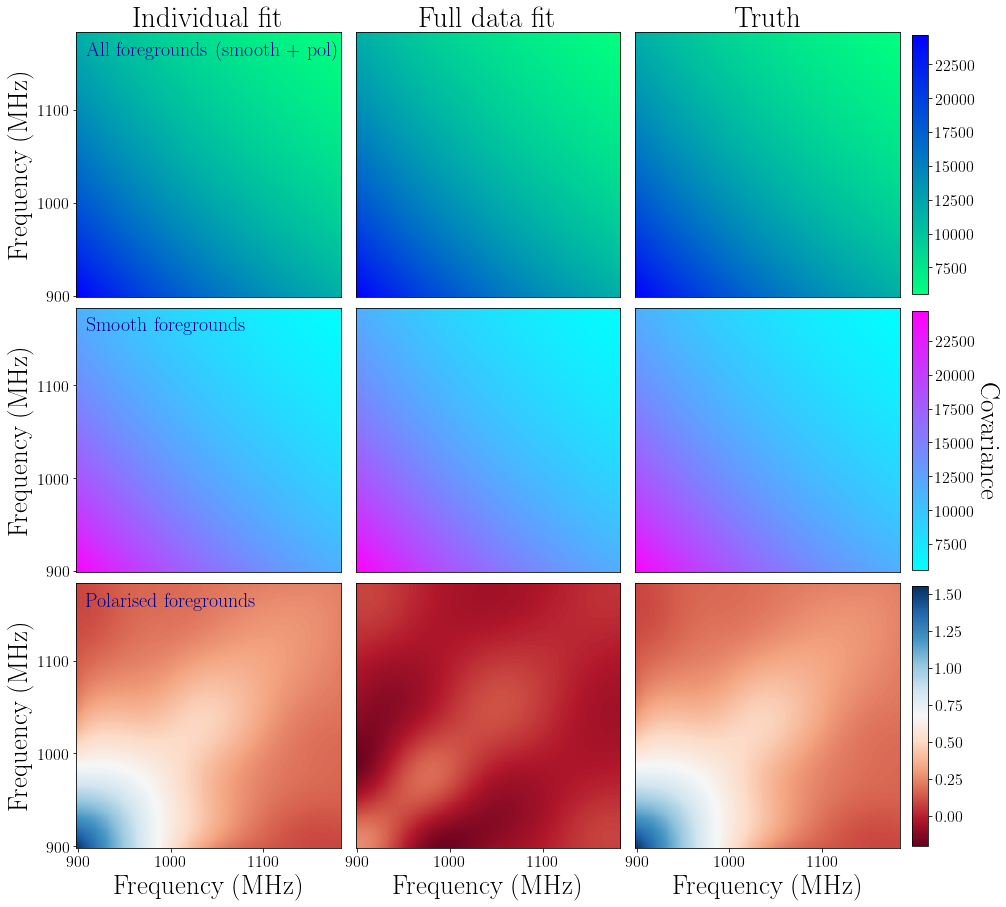

In [21]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
fig.subplots_adjust(hspace=0.05, wspace=0.005)

pos1 = ax1.imshow(cov_wpol_true, interpolation='nearest', origin='lower', cmap='winter_r', vmin=5560, vmax=24700)
ax1.text(10, 260, 'All foregrounds (smooth + pol)', c='darkblue', fontsize=20)
ax1.set_yticks([1, 101, 201])
ax1.set_yticklabels([900, 1000, 1100])
ax1.set_xticks([])
ax1.set_title('Individual fit', fontsize=29)
ax1.set_ylabel('Frequency (MHz)', fontsize=27)

pos = ax2.imshow(cov_wpol, interpolation='nearest', origin='lower', cmap='winter_r', vmin=5560, vmax=24700)
ax2.set_title('Full data fit', fontsize=29)
ax2.set_yticks([])
ax2.set_xticks([])

pos3 = ax3.imshow(C_FGwpol, interpolation='nearest', origin='lower', cmap='winter_r', vmin=5560, vmax=24700)
ax3.set_title('Truth', fontsize=29)
ax3.set_xticks([])
ax3.set_yticks([])

pos4 = ax4.imshow(cov_nopol_true, interpolation='nearest', origin='lower', cmap='cool', vmin=5560, vmax=24700)
ax4.text(10, 260, 'Smooth foregrounds', c='darkblue', fontsize=20)
ax4.set_yticks([1, 101, 201])
ax4.set_yticklabels([900, 1000, 1100])
ax4.set_xticks([])
ax4.set_ylabel('Frequency (MHz)', fontsize=27)

pos = ax5.imshow(cov_nopol, interpolation='nearest', origin='lower', cmap='cool', vmin=5560, vmax=24700)
ax5.set_yticks([])
ax5.set_xticks([])

pos = ax6.imshow(C_FGnopol, interpolation='nearest', origin='lower', cmap='cool', vmin=5560, vmax=24700)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_yticks([])

pos = ax7.imshow(cov_pol_true, interpolation='nearest', origin='lower', cmap='RdBu', vmin=-0.2, vmax=1.55)
ax7.text(10, 260, 'Polarised foregrounds', c='darkblue', fontsize=20)
ax7.set_xticks([1, 101, 201])
ax7.set_xticklabels([900, 1000, 1100])
ax7.set_yticks([1, 101, 201])
ax7.set_yticklabels([900, 1000, 1100])
ax7.set_xlabel('Frequency (MHz)', fontsize=27)
ax7.set_ylabel('Frequency (MHz)', fontsize=27)

pos = ax8.imshow(cov_pol, interpolation='nearest', origin='lower', cmap='RdBu', vmin=-0.2, vmax=1.55)
ax8.set_xticks([1, 101, 201])
ax8.set_xticklabels([900, 1000, 1100])
ax8.set_yticks([])
ax8.set_xlabel('Frequency (MHz)', fontsize=27)

pos9 = ax9.imshow(C_FGpol, interpolation='nearest', origin='lower', cmap='RdBu', vmin=-0.2, vmax=1.55)
ax9.set_xticks([1, 101, 201])
ax9.set_xticklabels([900, 1000, 1100])
ax9.set_yticks([])
ax9.set_xlabel('Frequency (MHz)', fontsize=27)

plt.subplots_adjust(hspace=0.04)
cax = plt.axes([0.905, 0.382, 0.015, 0.24])
cbar = plt.colorbar(pos4, cax=cax)
cbar.ax.set_ylabel(r'Covariance', rotation=270, fontsize=27)
cbar.ax.get_yaxis().labelpad = 25

cax2 = plt.axes([0.905, 0.127, 0.0152, 0.24])
cbar2 = plt.colorbar(pos9, cax=cax2)
cbar2.ax.get_yaxis().labelpad = 25

cax3 = plt.axes([0.905, 0.638, 0.0152, 0.24])
cbar3 = plt.colorbar(pos3, cax=cax3)
cbar3.ax.get_yaxis().labelpad = 25

#plt.savefig('figs/fg_covs', dpi=300, bbox_inches="tight")